# ECG Anlysis: R-Peak detection with Pan–Tompkins Algorithm
---

**Objective:** Load an ECG record from PhysioNet I-CARE database v2, filter the ECG signal, detect R peaks, and store the clean data (excluding the fisrt and last 5 minutes to avoid unstable gignal segments) in a dataframe.

In [5]:
import wfdb 
import numpy as np 
import pandas as pd 
import scipy.signal as sig 
import matplotlib.pyplot as plt

In [16]:
# Parameters

DB_DIR      = "i-care/2.0/training/0427"
RECORD_NAME = "0427_001_016_ECG"
CHANNEL     = 0            # channel index
TRIM_MIN    = 5            # minutes to trim from the start and end of the signal
FILTER_BAND = (5.0, 15.0)  # Hz (Pan–Tompkins filter band)

### Functions definition

In [ ]:
def bandpass(signal, fs, low=5.0, high=15.0, order=1):
    nyq = 0.5 * fs
    b, a = sig.butter(order, [low/nyq, high/nyq], btype='band')
    return sig.filtfilt(b, a, signal)

def pan_tompkins_indices(sig_f, fs):
    diff    = np.diff(sig_f, prepend=sig_f[0])
    squared = diff**2
    win     = int(0.150*fs)
    integ   = np.convolve(squared, np.ones(win)/win, mode='same')
    thresh  = 0.05*np.max(integ)
    refrac  = int(0.200*fs)
    peaks, _ = sig.find_peaks(integ, height=thresh, distance=refrac)
    # ±100 ms refinement on the filtered signal
    return refine(peaks, sig_f, fs, 100)

def refine(peaks, sig_f, fs, win_ms=100):
    w = int((win_ms/1000)*fs)
    return np.array([p-w+np.argmax(sig_f[max(0,p-w):p+w]) for p in peaks], int)

### Load the ECG record

In [18]:
rec  = wfdb.rdrecord(RECORD_NAME, pn_dir=DB_DIR)
fs   = rec.fs
ecg  = rec.p_signal[:, CHANNEL]
t    = np.arange(len(ecg))/fs
print(f"{len(ecg)=}  |  {fs=} Hz")
print(f"Avaliable channels   : {rec.sig_name}")

len(ecg)=1489500  |  fs=500 Hz
Avaliable channels   : ['ECG']


In [19]:
# Trim the signal
skip  = TRIM_MIN*60   # seconds
i_ini = int(skip * fs)
i_fin = int(len(ecg) - skip*fs)
ecg_trim = ecg[i_ini:i_fin]
t_trim   = t[i_ini:i_fin]

### Pan–Tompkins Filtering and R-Peak Detection

In [21]:
ecg_f = bandpass(ecg_trim, fs, *FILTER_BAND)
r_idx_trim  = pan_tompkins_indices(ecg_f, fs)
r_times_trim = t_trim[r_idx_trim]
print(f"R peaks detected in trimmed signal: {len(r_idx_trim)}")

R peaks detected in trimmed signal: 1780


In [22]:
df = pd.DataFrame({
    "time_s"   : t_trim,
    "ecg_filt" : ecg_f,
})
df["is_R"] = False
df.loc[r_idx_trim, "is_R"] = True   # marca booleana
# opcional: df["r_amp"] = np.where(df["is_R"], ecg_f[r_idx_trim], np.nan)

In [37]:
csv_path = f"{RECORD_NAME}_filtered.csv"
df.to_csv(csv_path, index=False)
print("DataFrame guardado", csv_path)

DataFrame guardado 0427_001_016_ECG_filtered.csv


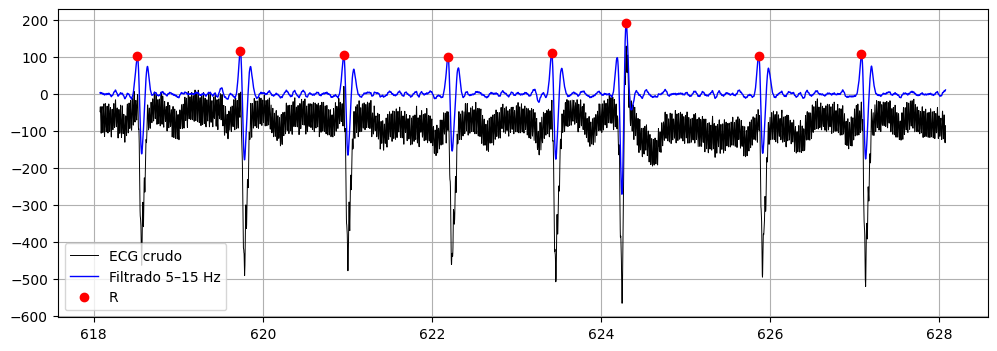

In [66]:
rng = np.random.default_rng()
span = int(10*fs)
start = rng.integers(0, len(ecg_trim)-span)
idx = slice(start, start+span)
plt.figure(figsize=(12,4))
plt.plot(t_trim[idx], ecg_trim[idx], 'k', lw=.7, label='ECG crudo')
plt.plot(t_trim[idx], ecg_f[idx],   'b', lw=1, label='Filtrado 5–15 Hz')
sel = r_idx_trim[(r_idx_trim>=idx.start)&(r_idx_trim<idx.stop)]
plt.plot(t_trim[sel], ecg_f[sel], 'ro', label='R')
plt.legend(); plt.grid(); plt.show();

### Estadística e histograma de intervalos RR  
A partir de los tiempos de los picos R (`r_times_trim`) se calculan los
intervalos RR (diferencias consecutivas).  
Se muestran:
* Estadísticos básicos (nº de intervalos, media, mediana, desvío estándar).  
* Un histograma de la distribución en ms para inspeccionar la variabilidad
  cardiaca y detectar posibles extrasístoles o artefactos.


Intervalos RR
  n           : 1721
  media (ms)  : 1282.4
  mediana (ms): 1286.0
  σ (ms)      : 31.8
  mínimo (ms)  : 1048.0
  máximo (ms)  : 1352.0


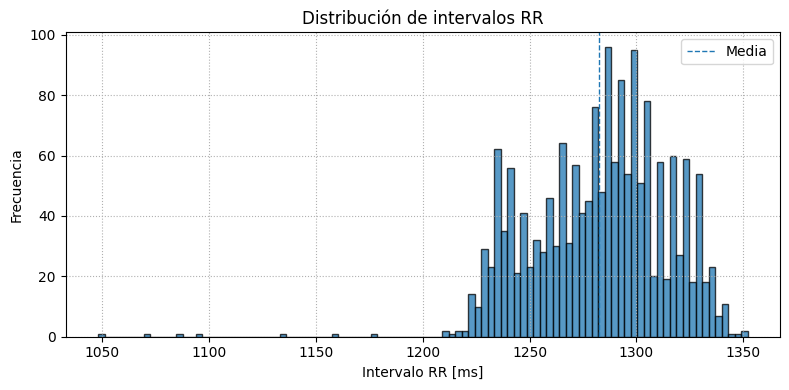

In [36]:
# --- Cálculo de intervalos RR ---
rr_ms = np.diff(r_times_trim) * 1000        # pasa de segundos a milisegundos
rr_ms = rr_ms[(rr_ms>1000) & (rr_ms<1400)]

# --- Estadísticos rápidos ---
print("Intervalos RR")
print(f"  n           : {rr_ms.size}")
print(f"  media (ms)  : {rr_ms.mean():.1f}")
print(f"  mediana (ms): {np.median(rr_ms):.1f}")
print(f"  σ (ms)      : {rr_ms.std(ddof=1):.1f}")
print(f"  mínimo (ms)  : {rr_ms.min():.1f}")
print(f"  máximo (ms)  : {rr_ms.max():.1f}")

# --- Histograma ---
plt.figure(figsize=(8,4))
# nbins = int(np.sqrt(rr_ms.size))            regla √n (puedes ajustar)
nbins= 100
plt.hist(rr_ms, bins=nbins, edgecolor='k', alpha=0.75)
plt.axvline(rr_ms.mean(), ls='--', lw=1, label='Media')
plt.xlabel('Intervalo RR [ms]')
plt.ylabel('Frecuencia')
plt.title('Distribución de intervalos RR')
plt.grid(True, ls=':')
plt.legend(); plt.tight_layout(); plt.show()